<a href="https://colab.research.google.com/github/ukhyun-lee/stock_market_analysis/blob/main/AI%EC%A4%91%EA%B8%89/AI%EC%8B%A4%EC%8A%B5_8%EC%9B%9421%EC%9D%BC(AlexNet%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
import time
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [13]:
#!unzip catdog.zip -d catdog/

cat_directory = '/content/catdog/train/cat/'
dog_directory = '/content/catdog/train/dog/'


cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
#train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요
#val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 합니다
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [14]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [15]:
size = 256   #사이즈 변경 깊이 깊은 network 때문에
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 256, 256])
0


In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())   #배치사이즈, 채널, 너비, 높이
print(label)

torch.Size([32, 3, 256, 256])
tensor([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0])


In [17]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [18]:
model = AlexNet()
print(model)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [20]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [21]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [23]:
num_epoch = 100
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/100
--------------------


<ipython-input-21-8b28962edeb7>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6927 Acc: 0.5109
Epoch 2/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6924 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6926 Acc: 0.5109
Epoch 3/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6926 Acc: 0.5109
Epoch 4/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6924 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6925 Acc: 0.5109
Epoch 5/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6925 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6925 Acc: 0.5109
Epoch 6/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6925 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6924 Acc: 0.5109
Epoch 7/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6924 Acc: 0.5109
Epoch 8/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6923 Acc: 0.5109
Epoch 9/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6922 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6923 Acc: 0.5109
Epoch 10/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6923 Acc: 0.5109
Epoch 11/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6924 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6922 Acc: 0.5109
Epoch 12/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6925 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6921 Acc: 0.5109
Epoch 13/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6921 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6921 Acc: 0.5109
Epoch 14/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6922 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6920 Acc: 0.5109
Epoch 15/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6923 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6920 Acc: 0.5109
Epoch 16/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6921 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6920 Acc: 0.5109
Epoch 17/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6921 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6919 Acc: 0.5109
Epoch 18/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6922 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6919 Acc: 0.5109
Epoch 19/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6918 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6918 Acc: 0.5109
Epoch 20/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6917 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6917 Acc: 0.5109
Epoch 21/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6918 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6917 Acc: 0.5109
Epoch 22/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6917 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6916 Acc: 0.5109
Epoch 23/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6917 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6916 Acc: 0.5109
Epoch 24/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6918 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6915 Acc: 0.5109
Epoch 25/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6915 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6914 Acc: 0.5109
Epoch 26/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6916 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6914 Acc: 0.5435
Epoch 27/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6917 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6914 Acc: 0.5543
Epoch 28/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6914 Acc: 0.5175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6913 Acc: 0.5543
Epoch 29/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6913 Acc: 0.5075


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6911 Acc: 0.5435
Epoch 30/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6909 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6910 Acc: 0.5435
Epoch 31/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6907 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6908 Acc: 0.5109
Epoch 32/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6903 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6908 Acc: 0.5217
Epoch 33/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6909 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6907 Acc: 0.5435
Epoch 34/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6907 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6906 Acc: 0.5435
Epoch 35/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6901 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6905 Acc: 0.5326
Epoch 36/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6903 Acc: 0.4950


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6903 Acc: 0.5217
Epoch 37/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6907 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6903 Acc: 0.5543
Epoch 38/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6895 Acc: 0.5225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6902 Acc: 0.5543
Epoch 39/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6896 Acc: 0.5100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6901 Acc: 0.5543
Epoch 40/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6895 Acc: 0.5150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6899 Acc: 0.5543
Epoch 41/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6897 Acc: 0.5075


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6898 Acc: 0.5543
Epoch 42/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6887 Acc: 0.5350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6898 Acc: 0.5435
Epoch 43/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6895 Acc: 0.5250


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6896 Acc: 0.5435
Epoch 44/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6896 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6895 Acc: 0.5543
Epoch 45/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6892 Acc: 0.5100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6893 Acc: 0.5543
Epoch 46/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6888 Acc: 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6893 Acc: 0.5435
Epoch 47/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6876 Acc: 0.5400


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6891 Acc: 0.5435
Epoch 48/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6877 Acc: 0.5525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6890 Acc: 0.5435
Epoch 49/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6881 Acc: 0.5350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6888 Acc: 0.5435
Epoch 50/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6868 Acc: 0.5500


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6887 Acc: 0.5543
Epoch 51/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6868 Acc: 0.5325


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6885 Acc: 0.5435
Epoch 52/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6861 Acc: 0.5225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6883 Acc: 0.5435
Epoch 53/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6859 Acc: 0.5550


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6881 Acc: 0.5435
Epoch 54/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6840 Acc: 0.5350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6880 Acc: 0.5435
Epoch 55/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6856 Acc: 0.5450


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6878 Acc: 0.5435
Epoch 56/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6848 Acc: 0.5425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6877 Acc: 0.5435
Epoch 57/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6849 Acc: 0.5525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6875 Acc: 0.5543
Epoch 58/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6831 Acc: 0.5600


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6874 Acc: 0.5543
Epoch 59/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6838 Acc: 0.5700


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6873 Acc: 0.5543
Epoch 60/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6826 Acc: 0.5525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6870 Acc: 0.5543
Epoch 61/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6821 Acc: 0.5500


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6867 Acc: 0.5543
Epoch 62/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6796 Acc: 0.5675


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6862 Acc: 0.5435
Epoch 63/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6799 Acc: 0.5800


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6858 Acc: 0.5435
Epoch 64/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6807 Acc: 0.5825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6854 Acc: 0.5435
Epoch 65/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6788 Acc: 0.5700


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6849 Acc: 0.5761
Epoch 66/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6788 Acc: 0.6050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6845 Acc: 0.5652
Epoch 67/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6787 Acc: 0.5900


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6840 Acc: 0.5761
Epoch 68/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6756 Acc: 0.5950


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6834 Acc: 0.5761
Epoch 69/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6778 Acc: 0.5800


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6829 Acc: 0.5652
Epoch 70/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6719 Acc: 0.6100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6826 Acc: 0.5761
Epoch 71/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6728 Acc: 0.5975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6815 Acc: 0.5652
Epoch 72/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6697 Acc: 0.6125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6810 Acc: 0.5978
Epoch 73/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6726 Acc: 0.6150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6790 Acc: 0.5870
Epoch 74/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6714 Acc: 0.6000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6770 Acc: 0.5652
Epoch 75/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6676 Acc: 0.6275


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6768 Acc: 0.5978
Epoch 76/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6663 Acc: 0.6425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6764 Acc: 0.5761
Epoch 77/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6639 Acc: 0.6200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6756 Acc: 0.5978
Epoch 78/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6654 Acc: 0.6125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6748 Acc: 0.5761
Epoch 79/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6636 Acc: 0.6275


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6710 Acc: 0.5870
Epoch 80/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6588 Acc: 0.6500


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6705 Acc: 0.5978
Epoch 81/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6666 Acc: 0.5925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6714 Acc: 0.5761
Epoch 82/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6658 Acc: 0.6225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6743 Acc: 0.5435
Epoch 83/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6617 Acc: 0.6300


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6721 Acc: 0.5870
Epoch 84/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6546 Acc: 0.6350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6682 Acc: 0.5870
Epoch 85/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6547 Acc: 0.6150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6679 Acc: 0.5761
Epoch 86/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6492 Acc: 0.6525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6681 Acc: 0.5652
Epoch 87/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6469 Acc: 0.6500


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6683 Acc: 0.5978
Epoch 88/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6369 Acc: 0.6525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6682 Acc: 0.5870
Epoch 89/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6493 Acc: 0.6375


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6678 Acc: 0.5761
Epoch 90/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6443 Acc: 0.6275


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6624 Acc: 0.6087
Epoch 91/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6433 Acc: 0.6300


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6633 Acc: 0.6196
Epoch 92/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6425 Acc: 0.6550


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6793 Acc: 0.5652
Epoch 93/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6544 Acc: 0.6200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6797 Acc: 0.5652
Epoch 94/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6488 Acc: 0.6200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6656 Acc: 0.5543
Epoch 95/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6367 Acc: 0.6525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6561 Acc: 0.6413
Epoch 96/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6356 Acc: 0.6350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6661 Acc: 0.5978
Epoch 97/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6327 Acc: 0.6350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6602 Acc: 0.6087
Epoch 98/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6236 Acc: 0.6850


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6591 Acc: 0.6304
Epoch 99/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6370 Acc: 0.6575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6702 Acc: 0.5978
Epoch 100/100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6445 Acc: 0.6300


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6838 Acc: 0.5761
Training complete in 4m 41s


In [31]:
import pandas as pd

id_list = []
pred_list = []
_id=0  #로직 지원 임시변수
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.to_csv('alexnet.csv', index=False)

<ipython-input-31-c0a9fe81fd83>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
res.head()

,id,label
0,145,0.447420
1,211,0.695749
2,162,0.697669
3,200,0.638069
4,210,0.723508


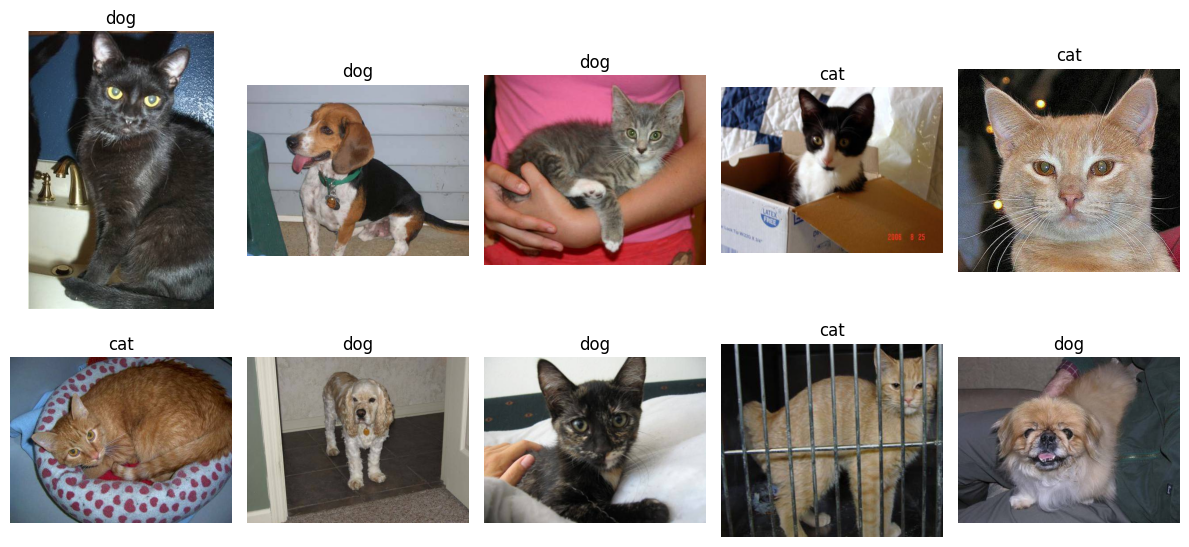

In [33]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths)

https://www.kaggle.com/c/dogs-vs-cats/data